# 第5章 因果推論と機械学習の融合

## 5.1 機械学習を用いた因果推論の全体像

機械学習を用いた因果推論でできること

1. 因果効果の推定とその予測精度の評価
   * メタラーナー(Meta-learner): 複数の基本的な予測モデルを組み合わせて因果効果を推測するメタラーナーの種類
     * S-leaner
     * T-learner
     * X-leaner
     * DR-leaner
   * 既存の機械学習手法を、CATEを直接推定するために変更したもの(アンサンブル学習、ノンパラメトリックな手法)
     * Causal Forest
     * Causal BART
2. 複数の選択肢の中で期待効用が最大のものを予測: [5.7節](#54-doubledebiased-machine-leaningdml)で説明

## 5.2 因果推論に機械学習を使用する際の注意点

### 5.2.1 識別仮定に関する注意点

特に機会学習では多くの変数を用いるので、識別仮定を満たすかの判断が難しい

1. 交絡因子により因果関係を誤る可能性
   例えば航空会社が休日に需要が多くなるので値上げをした場合、価格が高くなれば売上げが上がるという逆の推論が出来上がる可能性がある
   因果推論のフレームワークを適切に使用すること

2. 処置変数が独立でない可能性
   処置変数が潜在的結果変数と条件付き独立であるという仮定が、未観測の交絡因子により崩れる可能性がある。ただし、処置変数に影響するが、結果変数に影響を与えない1つ以上の操作変数を識別できる場合は、条件付き独立の仮定は不要。
   例えば、航空会社のチケット代に関して、燃料費は変動が航空券の需要(結果変数)と独立しているが、売上げには航空券の価格(処置変数)を通じて影響するので、操作変数とみなせる
   ![図5.4](images/chap5/image.png)
   事前実験を使用して対応できる場合がある

### 5.2.2 推定に関する注意点

3. 学習時と予測時のデータの性質が異なる(分布シフトの発生の)可能性
   機械学習は学習データとテストデータが同一の分布から独立にサンプリングされる(independent and identically distributed: i.i.d.)という仮定のもと使用される
   過去データを用いたオフライン評価と、現実環境におけるオンライン評価で、コンバージョンレート(CVR)が向上しないなど
   COVID-19パンデミック下で顧客の行動が変化し、Amazonの予測アルゴリズムが機能不全になった

   このような分布シフトに対応する手法も提案されているが、最終的にはA/Bテストが有効
4. 過適合、正則化バイアス
   [5.4節](#57-因果的意思決定)で説明
5. データの質が悪く、CATE推定の信頼性が低い
   機械学習は大量のデータをを必要とするので、データの質が重要。また、同じモデルでもCATEを推定する対象(属性)によって精度が変わる可能性がある

### 5.2.3 結果及びモデルの解釈・公平性に関する注意点

6. モデルが複雑になり解釈が難しい
   現状複雑なモデルは説明不能だが、SHAPなどで対応できる場合がある。今後の研究に期待

7. 不当な差別を助長した予測をする可能性
   データセット内にすでに特定の属性(例えば人種、性別、宗教など)にバイアスが存在する場合、モデルもそれを反映する可能性がある。
   モデルの設計の段階で公平性を担保するように考慮する必要がある。

## 5.3 メタラーナー

CATEの高精度化のための手法。Uberが2021年時に使用を発表した。

CATEの条件が共変量$X=x$として設定されていると仮定する。

このとき、
1. 条件付き独立: $\{ Y(1), Y(0) \} \perp T|X=x$
2. 条件付き正値性: $( 0 < P(T=1|X=x) < 1)$
3. SUTVA

これらを仮定したうえで、CATEは結果変数の条件付き期待値の差分$\tau(x)$となる
$$
\begin{align}
&\mu_1(x) = E[Y(1) | X=x] \nonumber\\
&\mu_0(x) = E[Y(0) | X=x] \nonumber\\
&\tau(x) = \mu_1(x) - \mu_0(x) = E[Y(1) - Y(0)|X = x] \nonumber
\end{align}
$$

しかし、$Y(1)|X=x$のデータを取得すると$Y(0)|X=x$が取得できない、もしくはその逆。となるため、この取得できないデータを機械学習を用いて推定する。

### 5.3.1 S-leaner、T-leaner、X-leaner

1. S-leaner: 処置群と対照群を1つのモデルで推定する方法
   全データに対して、XとTからYを予測するモデルを用いる
   $$
   \hat{\tau_S}(x) = \hat{\mu}(x, 1) - \hat{\mu}(x, 0)
   $$
2. T-leaner: 処置群と対照群をそれぞれ別のモデルで推定する方法
   処置群と対照群の各データを使用した2つのモデルを用いて推測する
   $$
   \hat{\tau_T}(x) = \hat{\mu_1}(x) - \hat{\mu_0}(x)
   $$

#### S-leanerとT-leanerの課題
* S-leaner
    * 処置効果にバイアスが発生する傾向がある(特に処置変数Tの結果変数Yへの影響が、共変量Xの影響に比べて小さい場合、ゼロに向かってバイアスがかかる)
    * 正則化された機械学習モデルを用いるので、この正則化により、推定される処置効果が制限される可能性がある
      [次節のDouble/debiased machine leaning](#54-doubledebiased-machine-leaningdml)で対応
* T-leaning
    * データを処置群と対照群に分けて機械学習する際に、正則化バイアスが発生する可能性がある(特に処置群のサンプルサイズが小さく、対照群のサンプルサイズが大きい場合)。つまり、不必要に単純な構造になるなどの弊害が出る

3. X-leaner
   上記のような問題への対応策の一つ。処置あり/なしのそれぞれの場合の効果を推定したうえで、以下の2点を行い精度を高めていく
   * 結果変数の正解データと、推定した因果効果の差分も活用
   * 傾向スコアでの重み付け

X-leanerの実行手順は以下となる
#### Step 1 T-leanerの構築
T-leanerを用いて$\hat{\mu_1}(x)$と$\hat{\mu_0}(x)$を推定

#### Step 2 反実仮想の推定と2通りのCATEの推定・調整
処置群と対照群のITE(個体の因果効果)を推定: $\hat{\mu_1}(x)$と$\hat{\mu_0}(x)$と結果ヘンス$Y_i(1)$と$Y_i(0)$の差$\widetilde{D_i^1}$, $\widetilde{D_i^2}$を算出

$$
処置群: \widetilde{D_i^1} = Y_i(1) - \hat{\mu_1}(X_i^1) \\
対象群: \widetilde{D_i^0} = \hat{\mu_0}(X_i^0) - Y_i(0)
$$
* $\hat{\mu_1}(X_i^1)$と$\hat{\mu_0}(X_i^0)$は共変量($X_i^1$, $X_i^0$)を用いた潜在結果変数であり、推測値
* $Y_i(1)$、$Y_i(0)$は実測値

理想的には上式の右辺は処置群・対照群ともに0(実測値と推定値は同じ)となるべき

$X = x$のとき、因果効果\tau(x)は
$\tau_1(x) = E[\widetilde{D^1} | X=x]$
$\tau_0(x) = E[\widetilde{D^0} | X=x]$

として、
$\tau(x) = \tau_1(x) = \tau_0(x)$
つまり、処置群でも対照群でも因果効果は同じとなる。この理想に近づけるため$\hat{\tau_1}(x)$、$\hat{\tau_0}(x)$をモデルから推定する

ただしこのままではT-leaningの課題であったように処置群のサンプルサイズが小さい場合に$\hat{\tau_0}(x)$の推定精度が低い可能性があるので、CATE$\hat{\tau_1}(x)$、$\hat{\tau_0}(x)$に対して、重み付けを行い、最終的に$\hat{\tau}(x)$を得る
$$
\hat{\tau}(x_i) = \hat{\pi}(x_i)\hat{\tau_0} + (1 - \hat{\pi}(x_i))\hat{\tau_1}(x_i)
$$

* $\hat{\pi}(x)$: 重み関数(=傾向スコア)。勾配ブースティングなどを用いる

#### S-leaner、 T-leaner、X-leanerのまとめ 
「社会的圧力を利用してアメリカの選挙での投票率を上げられるかを探求した大規模な投票動員(Get-Out-the-Vote)の実験」(Gerber, Green, and Larimer 2008)

![図5.10](images/chap5/image-1.png)

「戸別訪問により、マイアミでのトランスフォビア(トランスジェンダーの人への否定的な態度や不寛容)を持続的に減少させることができるかどうかを探求した実験」のデータ(Broockman
Kalla 2016)

![図5.11](images/chap5/image-2.png)

いすれも、X-leanerのほうが良好な結果を示されている

### 5.3.2 Doubly Robust Leaner

* DR-leaner: T-leanerを理論上改善した手法

T-leanerをベースに、処置群モデルと対照群モデルそれぞれの推定値の残差に逆確率重み付け(IPW)を追加したもの

結果変数モデルと傾向スコアモデルを組み合わせることで、傾向スコアが小さい場合にIPWモデルの推定値が大きくばらつくなどの欠点に対応。第3章の二重にロバストな推定法の考え方と同じ。

実行手順
1. データセットを2つに分割($D_1, D_2$)
2. $D_1$を用いて結果変数モデルと傾向スコアモデルを構築
3. 結果変数モデル($\hat{\mu}_1(X_i), \hat{\mu}_0(X_i)$)と傾向スコアモデル($\hat{\pi}(X_i)$)から以下の式の推定量$\phi$を計算
   $$
   \phi = \hat{\mu}_1 (X_i)
      + \frac{T_i (Y_i - \hat{\mu}_1 (X_i))}
         {\hat{\pi}(X_i)}
      - \left(
            \hat{\mu}_0(X_i)
            + \frac{(1-T_i) (Y_i - \hat{\mu}_0 (X_i))}
            {1 - \hat{\pi}(X_i)}
      \right) \\
   
   \hat{\tau}_{DR} = E\left[ \phi | X=x \right]
   $$
4. 最後に$\phi$と$D_2$を用いて$\hat{\tau}_{DR}$を推定

上式では分母に傾向スコアモデル推定値($\hat{\pi}(X_i)$)があるため、極端な$\hat{\pi}(X_i)$だと、大きな$\hat{\tau}_{DR}$につながる可能性があるため、傾向スコア分布を確認と調整が必要なケースがある

### 5.3.3 メタラーナーの実行手順
問題設定: 売上に対するキャンペーンの効果検証(CATEの推定: 顧客の収入別のキャンペーン効果)をメタラーナーの4種類のモデルで行い、どのモデルが最も精度が高いか、また、推定したCATEはどの程度かを確認する。

#### Step 1 ライブラリとデータの準備
* econmlを使用する
* データ生成を行う。生成するデータは以下。
1. 共変量$X$: 平均が0で、共分散が単位行列である正規分布から生成
   $$
   X \sim N(0, I_d)
   $$
   $I_d$: $d \times dの単位行列$
2. 処置変数$T$: 共変量$X$に基づいて、特定の傾向スコア(propensity score)を用いて2項分布から生成
   $$
   T_i \sim Binominal(1, \pi(X_i))
   $$
   $\pi(X_i)$: 共変量$X_i$に依存する処置の傾向スコア

3. 結果変数$Y$: 処置なしの結果$Y(0)$と処置効果$\tau(X)$($T=1$処置適用のときのみ)の和として生成
   $$
   Y_i = Y_i(0) + \tau(X_i) \cdot T_i
   $$
   $Y_i(0)$: 処置なしの結果
   $\tau(X_i)$: 共変量X_iに基づく処置効果
   

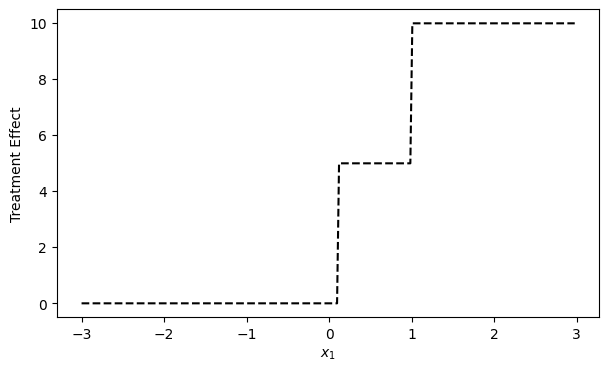

In [1]:
from typing import Any

import matplotlib.pyplot as plt
import numpy as np

"""使用データの生成"""


"""各関数
controls_outcome
treatment_effect
propensity
の定義"""


class ControlsOutcome:
    """処置を受けていない場合の結果を計算するクラス.

    与えられた共変量xに対してその共変量と係数betaのドット積を計算し、正規分布ノイズを加えて結果を返す.
    """

    def __init__(self, d: int) -> None:
        self.rng = np.random.default_rng(1)
        # 各共変量の影響を表す係数を生成
        self.beta = self.rng.uniform(-2, 2, d)

    # 与えられた共変量xに対してその共変量と係数betaのドット積を計算し、
    # 正規分布ノイズを加えて結果を返す
    def __call__(self, x: np.ndarray) -> float:
        """与えられた共変量xに対してその共変量と係数betaのドット積を計算し、正規分布ノイズを加えて結果を返す."""
        return np.dot(x, self.beta) + self.rng.normal(0, 1)


def treatment_effect(x: np.ndarray) -> float:
    """処置効果を計算して返す."""
    threathold_max = 1
    threathold_min = 0.1
    # x[1]はは顧客の収入とする。他の要素は顧客の何等かの属性データとする
    return 10 if x[1] > threathold_max else (5 if x[1] > threathold_min else 0)


def propensity(x: np.ndarray) -> float:
    """傾向スコア(処置を受ける確率)を計算して返す."""
    threathold_max = 0.5
    threathold_min = -0.5
    # x[2]が-0.5から0.5の間の場合、確率0.7を返す
    # それ以外の場合、確率0.3を返す
    return 0.7 if (x[2] > threathold_min and x[2] < threathold_max) else 0.3


def generate_data(
    n: int,
    d: int,
    controls_outcome: callable,
    treatment_effect: callable,
    propensity: callable,
) -> tuple[Any, np.ndarray[Any], np.ndarray[Any, np.dtype[np.float64]]]:
    """使用するデータを生成."""
    rng = np.random.default_rng(1)
    # 共変量を生成
    X = rng.multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n)
    # 処置変数を生成
    # 各共変量に対して、propensity関数を用いて傾向スコアを計算
    # この確率を基に二項分布から処置変数を生成
    T = np.apply_along_axis(lambda x: rng.binomial(1, propensity(x), 1)[0], 1, X)
    # 結果変数の生成
    # Y0
    Y0 = np.apply_along_axis(lambda x: controls_outcome(x), 1, X)
    # Y1
    treatment_effect = np.apply_along_axis(lambda x: treatment_effect(x), 1, X)
    Y = Y0 + treatment_effect * T
    return (Y, T, X)


d = 10  # 共変量を10個に設定
n = 1000  # 学習データのサンプルサイズ
control_outcome = ControlsOutcome(d)

Y, T, X = generate_data(n, d, control_outcome, treatment_effect, propensity)

"""実際の処置効果を確認"""
rng = np.random.default_rng(1)
# テストデータのサンプルサイズ
n_test = 250
# テストデータの共変量を生成
X_test = rng.multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n_test)
# グラフ描画用の設定
plot_range_s = -3
plot_range_e = 3
pitch = (plot_range_e - plot_range_s) / n_test
X_test[:, 1] = np.arange(plot_range_s, plot_range_e, pitch)
true_effects = np.array([treatment_effect(x) for x in X_test])
plt.figure(figsize=(7, 4))
plt.plot(
    X_test[:, 1],
    np.apply_along_axis(treatment_effect, 1, X_test),
    color="black",
    ls="--",
    label="Baseline",
)
plt.xlabel("$x_1$")
plt.ylabel("Treatment Effect")
plt.show()


#### Step 2 DAGの確認
![図5.14](images/chap5/image-3.png)

#### Step 3 識別仮定の確認
* CATEを推定する場合は特にこの手順は重要。処置群と対照群を条件付きで比較するので、識別仮定を満たすことが困難
* CATEを計算する前だけでなく、計算後もある条件での異常値の発生がないかなどを確認する。Step4で実際に実行結果を可視化して確認する

#### Step 4 因果効果の推定、精度検証(モデル選択)、可視化

精度指標はMSEを用いる
S, T, X, DR-leanerすべてのモデルにおいて学習を行いテストデータに対する精度検証を行う

In [2]:
from econml.dr import DRLearner
from econml.metalearners import SLearner, TLearner, XLearner
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# ベースモデルの設定
GBR = GradientBoostingRegressor()  # 勾配ブースティングによる回帰クラスの設定
GBC = GradientBoostingClassifier()  # 勾配ブースティングによる分類クラスの設定

# モデルの初期化
models = {
    "S-Learner": SLearner(overall_model=GBR),
    "T-Learner": TLearner(models=(GBR, GBR)),
    "X-Learner": XLearner(models=(GBR, GBR)),
    "DR-Learner": DRLearner(model_regression=GBR, model_propensity=GBC),
}

# モデルの学習と評価
np.random.seed(1)  # 乱数のシードを設定
results = {}
for name, model in models.items():
    model.fit(Y, T, X=X)
    preds = model.effect(X_test)  # テストデータを用いてCATEを推定
    mse = mean_squared_error(true_effects, preds)  # MSEを計算
    results[name] = mse
results

{'S-Learner': 1.683292733630935,
 'T-Learner': 2.471624662541262,
 'X-Learner': 0.7130158557383657,
 'DR-Learner': 7.61147207282376}

X-leanerのMSEが最も低く予測精度が高いことがわかる
度のモデルが良いかはデータ次第なので、複数モデルで比較すること。

以下でこのモデルの結果を可視化する

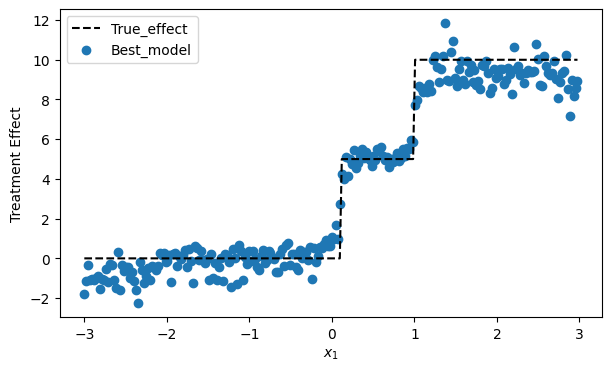

In [3]:
# 最も精度の高いモデルを選択
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]

# CATEの推定結果の可視化
plt.figure(figsize=(7, 4))
plt.plot(
    X_test[:, 1],
    np.apply_along_axis(treatment_effect, 1, X_test),
    color="black",
    ls="--",
    label="True_effect",
)
plt.scatter(X_test[:, 1], best_model.effect(X_test), label="Best_model")
plt.xlabel("$x_1$")
plt.ylabel("Treatment Effect")
plt.legend()
plt.show()

X-leanerで真の値に近い値が推定できている事がわかる。このことから、$x[1]$(顧客の収入)が高いほうがキャンペーンの効果が高かった事がわかる。

### 5.3.4 メタラーナーの課題

回帰分析や傾向スコア分析と同様に、未観測への交絡因子への対応が課題。

ドメイン知識から未観測の交絡因子の存在が考えられる場合には、第6章の感度分析を行うなどの対応が推奨される。

また、限定的な未観測の交絡因子の存在下でCATE分析を行うB-leanerという方法も提案されている

## 5.4 Double/de-biased machine leaning(DML)

* 機械学習を用いた因果効果推定の問題点: 過適合と正則化バイアスが生じている可能性がある[5.1節](#51-機械学習を用いた因果推論の全体像)

この問題の詳細と、対応方法について述べる

### 5.4.1 過適合の問題及びその解決策

過適合: モデルが学習データに当てはまりすぎる問題

対応方法は基本的にデータ分割()

1. Sample-split: データセットを学習データと検証データに分割。学習データを関数の推定に使用、検証データを因果効果の推定に用いることで過適合バイアスを低減する
2. Cross-fit: サンプルを入れ替えて推定を繰り返し、推定された因果効果を平均化する。k-foldクロスバリデーションと同じ考え方

![図5.14](images/chap5/image-4.png)

各方法の処理過程(フルサンプルを追加)

![図5.15](images/chap5/image-5.png)

各方法のバイアスと分散の違い

![図5.16](images/chap5/image-6.png)

### 5.4.2 正則化バイアスの問題及びその原因

正則化: 学習時のパラメーターに一定の制約を課してモデルの自由度を下げ、過適合を防ぐ手段

正則化バイアス: 正則化が逆にバイアスを生じさせること

例えば、図5.17の正規分布の例のように、推定が真の値から少しずれること。

![図5.17](images/chap5/image-7.png)

* $\hat\theta_0$: 推定値
* $\theta_0$: 真の値
* $\hat\sigma$: 推定した標準偏差

原因
$\sqrt{n}$一致性($\sqrt{n}$-consistency)の収束条件を満たしていないこと

* 一致性: サンプルサイズ$\infty$で推定量が真の値に確率収束すること
* $\sqrt{n}$一致性: 一致性に、推定量が真のパラメータに収束する速度の条件を付けたもの。

サンプルサイズnが増えると、推定量と真の値の差が$1/\sqrt{n}$で収束すること(サンプルサイズ4倍 → 差が1/2になる)

$$
\sqrt{n}(\hat{\theta}_0 - \theta_{0}) \to  N(0,\sigma^2),\ n \to \infty
$$

$\sqrt{n}(\hat{\theta}_0 - \theta_{0})$が収束する部分。

基本的な線形回帰は\sqrt{n}$一致性を満たすが、正則化を備えた機械学習では満たさない場合が多い。

それはぜか、具体的に以下の式で表される部分線形回帰の例を考える。

$$
Y = \theta_0 T + g_0(X) + \varepsilon_Y,\ E\left[\varepsilon_Y | X,T\right] \\
T = m_0(X) + \varepsilon_T,\ E\left[\varepsilon_T|X\right] \\
$$

* $Y$: 結果変数
* $T$: 処置変数
* $X = (X_1, \cdots, X_p)$: 共変量(ベクトル)
* $\theta_0$: 因果効果(今回求めたいパラメータ)
* $g_0(X), m_0(X)$: 共変量$X$の任意の関数
* $\varepsilon_Y, \varepsilon_T$: 誤差項
  $\varepsilon_Y$は$X,Y$と独立
  $\varepsilon_T$は$X$と独立

サンプルをn個ずつにランダム分割する。観測番号$i = 1, \cdots,n$

ここで損失関数を以下のとおり定義する

$$
S(\theta_0) = \sum_{i=1}^n (Y_i - \theta_0 T_i + g_0(X_i))^2 \\
$$

これを第3章の回帰分析で紹介したように偏微分すると、

$$
\frac{\partial S(\theta_0)}
{\partial \theta_0}
    = -2 \sum_{i=1}^n T_i
    (Y_i - \theta_0 T_i + g_0 (X_i))
$$

ここで、左辺を0としたときの推定値$\hat{\theta}_0$は以下となる。

$$
\hat{\theta}_0
    = \left(\frac{1}{n} \sum_{i=1}^n T_i^2\right)^{-1}
    \cdot \frac{1}{n} \sum_{i=1}^nT_i(Y_i - \hat{g}_0(X_i))
$$

右辺の$\hat{g}_0(X)$は機械学習を用いて算出した推定値。この式を使用して、単純に機械学習モデルを使用した場合の収束を見ていく。

$\sqrt{n}(\hat{\theta}_0 - \theta_{0})$の計算式が必要なので、theta_{0}を持ってくるため最初の結果変数$Y$の式を代入。

$$
\hat{\theta}_0
    = \left(\frac{1}{n} \sum_{i=1}^n T_i^2 \right)^{-1}
    \cdot \frac{1}{n} \sum_{i=1}^n
    T_i \left(
        \theta_0 T_i + g_0(X_i) + \varepsilon_{Y_i} - \hat{g}_0(X_i)
    \right) \\
$$

この式を左辺が$\sqrt{n}(\hat{\theta}_0 - \theta_{0})$となるよう整理する。

$$
\begin{align}
\sqrt{n}(\hat{\theta}_0 - \theta_{0})
    = \underset{a}{\underline{
        \left(
            \frac{1}{n} \sum_{i \in I} T_i^2
        \right)^{-1}
        \frac{1}{\sqrt{n}} \sum_{i \in I} T_i \varepsilon_{Y_i}
    }}
    
    + \underset{b}{\underline{
        \left(
            \frac{1}{n} \sum_{i \in I} T_i^2
        \right)^{-1}
        \frac{1}{\sqrt{n}} \sum_{i \in I} T_i
        \left(
            g_0(X_i) - \hat{g}_0(X_i)
        \right)
    }} \nonumber
\end{align}
$$

この式の右辺が$n\to\infty$で、収束するかを確認すると、

* aの部分: $n\to\infty$のもとで、平均0、ある標準偏差を持つ正規分布に近づく
* bの部分: $\hat{g}_0(X_i)$は機械学習の推定量であり、正則化項の影響で収束速度は基本的に$n^{-\phi_g}(\phi_g \lt 1/2)$となる。
  ここでこの2項目の収束速度を$\sum$の係数と、$n^{-\phi_g}$から計算すると、

  * $\sqrt{n}\ \left(= (1/n)^{-1} \times 1/\sqrt{n}\right)$
  * $n^{-\phi_g}\ \left(= g_0(X_i) - \hat{g}_0(X_i)\right)$

  となるので、収束速度は$\sqrt{n} \cdot n^{-\phi_g} \to \infty$となり、収束せず、推定結果にバイアスが残る事がわかる

### 5.4.3 正則化バイアスおよび過適合へのDMLのアプローチ
このバイアス対処するのに、ここではFWL定理を使用する。

FWL定理(Frisch-Waugh-Lovell定理): 分割した説明変数を用いて回帰係数を求め、最小二乗推定量と同じ結果を得ることができるという定理

これを用いて、先述の式
$$
Y = \theta_0 T + g_0(X) + \varepsilon_Y,\ E\left[\varepsilon_Y | X,T\right]
$$
において、$\theta_0$の効果を算出し、それ以外の変数を制御する。具体的には共変量$X$を含む$g_0(X)$を除いた$\theta_0$の式を導出する。

FWL定理を、今回の部分線形回帰モデルに当てはめて表現すると、$Y, T$それぞれの残差を算出し、それらを用いて$\theta_0$を算出することになる

* $\hat{\varepsilon}_Y, \hat{\varepsilon}_T$: それぞれY, Tの残差
* $\hat{Y}, \hat{T}$: Xを用いた推定値
* $\zeta$: 残差。$\theta_0, \zeta$は独立

Step
1. $Y$を$X$で回帰: $\hat{\varepsilon_Y} = Y - \hat{Y}$
2. $T$を$X$で回帰: $\hat{\varepsilon_T} = T -\hat{T}$
3. $\hat{\varepsilon}_Y$を$\hat{\varepsilon}_T$で回帰して$\theta_0$を推定: $\hat{\varepsilon_Y} = \hat{\varepsilon_T}\theta_0 + \zeta$

Step3の数式
$$
\hat{\varepsilon_Y} = \hat{\varepsilon_T}\theta_0 + \zeta
$$
は最終的に共変量$X$を用いて、残差$\zeta$を最小化する$\theta_0$を推定可能な形となった

また、Step3の式の標本対応(母集団にに置いて定義されたパラメータと同様の性質を、標本において満たす統計量)は、標本数$n$と、$\zeta$を最小化する$\theta_0$について整理すると以下となる。
$$
\hat{\theta}_0
= \left(
    \sum_i^n \hat{\varepsilon}_{T_i}^2
\right)^{-1}
\sum_i^n \hat{\varepsilon}_{T_i} \hat{\varepsilon}_{Y_i}
$$

DMLの実行手順
Step
1. データを1:1に分割: 学習データと検証データに分割した後、クロスフィットを用いて学習データを使って推定。検証データはStep 2で用いる。
2. 残差を計算: $T$と$Y$を推定したものを$\hat{m}(X), \hat{g}(X)$とし、それぞれの推定誤差$T - \hat{m}(X), Y - \hat{g}(X)$を$\hat{\varepsilon}_Y, \hat{\varepsilon}_T$とする。
   $\hat{\varepsilon}_Y, \hat{\varepsilon}_T$は可能な限り小さくする
3. FWL定理と直行条件を使用: $\hat{\varepsilon}_Y$を$\hat{\varepsilon}_T$に回帰し、直行条件により$\theta_0$を推定
   標本数をnとすると、以下の式となる。
   $$
    \hat{\theta}_0
    = \left(
        \sum_i^n \hat{\varepsilon}_{T_i}^2
    \right)^{-1}
    \sum_i^n \hat{\varepsilon}_{T_i} \hat{\varepsilon}_{Y_i}
   $$

![図5.18](images/chap5/image-8.png)

以上の手順を踏むことで、DMLでは$|\sqrt{n}(\hat{\theta_0} - \theta_0)|$が収束して、$\hat{\tau}_{DR} = E\left[\phi | X=x \right]$の分布を持ち、$\sqrt{n}$一致性の条件を満たす事になり、結果として正則化バイアスに対応するとされている。

さて、ここでDMLを用いてCATEの推定値は、FWL定理の式を用いて以下となる。

* $\hat{\theta}$: CATE推定量
* $\Theta$: $\theta$がとりうる値の範囲
$$
\hat{\theta}
= \arg \operatorname*{min}_{\theta \in \Theta}
E \left[
    \hat{\varepsilon}_Y
    - (\theta(X) \hat{\varepsilon}_Y)^2
\right]
$$

### 5.4.4 DMLの実行手順



#### Step 1 ライブラリとデータの準備
econmlライブラリのLinerDMLと、CausalForestDMLを使用する
* LinearDML: 線形回帰モデル
* CausalForestDML: 非線形データに対応するためのモデル(CausalForestは[5.5.1項](#551-Causal forest)で概要を説明)

その他のライブラリと生成データ、及びベースモデルの設定は[5.3.3項](#533-メタラーナーの実行手順)と同様
#### Step 2 DAGの確認、Step 3 識別仮定の確認
[5.3.3項](#533-メタラーナーの実行手順)と同様

識別仮定を満たすとする

#### Step 4 因果効果の推定、結果の検証
2種類のモデルを使用して因果効果の推定をする

In [10]:
"""使用データの生成(5.3.3と同じ)."""
from typing import Any  # noqa: E402

import numpy as np  # noqa: E402

"""各関数
controls_outcome
treatment_effect
propensity
の定義"""


class ControlsOutcome:
    """処置を受けていない場合の結果を計算するクラス.

    与えられた共変量xに対してその共変量と係数betaのドット積を計算し、正規分布ノイズを加えて結果を返す.
    """

    def __init__(self, d: int) -> None:
        self.rng = np.random.default_rng(1)
        # 各共変量の影響を表す係数を生成
        self.beta = self.rng.uniform(-2, 2, d)

    # 与えられた共変量xに対してその共変量と係数betaのドット積を計算し、
    # 正規分布ノイズを加えて結果を返す
    def __call__(self, x: np.ndarray) -> float:
        """与えられた共変量xに対してその共変量と係数betaのドット積を計算し、正規分布ノイズを加えて結果を返す."""
        return np.dot(x, self.beta) + self.rng.normal(0, 1)


def treatment_effect(x: np.ndarray) -> float:
    """処置効果を計算して返す."""
    threathold_max = 1
    threathold_min = 0.1
    # x[1]はは顧客の収入とする。他の要素は顧客の何等かの属性データとする
    return 10 if x[1] > threathold_max else (5 if x[1] > threathold_min else 0)


def propensity(x: np.ndarray) -> float:
    """傾向スコア(処置を受ける確率)を計算して返す."""
    threathold_max = 0.5
    threathold_min = -0.5
    # x[2]が-0.5から0.5の間の場合、確率0.7を返す
    # それ以外の場合、確率0.3を返す
    return 0.7 if (x[2] > threathold_min and x[2] < threathold_max) else 0.3


def generate_data(
    n: int,
    d: int,
    controls_outcome: callable,
    treatment_effect: callable,
    propensity: callable,
) -> tuple[Any, np.ndarray[Any], np.ndarray[Any, np.dtype[np.float64]]]:
    """使用するデータを生成."""
    rng = np.random.default_rng(1)
    # 共変量を生成
    X = rng.multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n)
    # 処置変数を生成
    # 各共変量に対して、propensity関数を用いて傾向スコアを計算
    # この確率を基に二項分布から処置変数を生成
    T = np.apply_along_axis(lambda x: rng.binomial(1, propensity(x), 1)[0], 1, X)
    # 結果変数の生成
    # Y0
    Y0 = np.apply_along_axis(lambda x: controls_outcome(x), 1, X)
    # Y1
    treatment_effect = np.apply_along_axis(lambda x: treatment_effect(x), 1, X)
    Y = Y0 + treatment_effect * T
    return (Y, T, X)


d = 10  # 共変量を10個に設定
n = 1000  # 学習データのサンプルサイズ
control_outcome = ControlsOutcome(d)
rng = np.random.default_rng(1)
# テストデータのサンプルサイズ
n_test = 250

Y, T, X = generate_data(n, d, control_outcome, treatment_effect, propensity)
# テストデータの共変量を生成
X_test = rng.multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n_test)
# グラフ描画用の設定
plot_range_s = -3
plot_range_e = 3
pitch = (plot_range_e - plot_range_s) / n_test
X_test[:, 1] = np.arange(plot_range_s, plot_range_e, pitch)
true_effects = np.array([treatment_effect(x) for x in X_test])


In [19]:
from econml.dml import CausalForestDML, LinearDML
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# ベースモデルの設定
GBR = GradientBoostingRegressor()  # 勾配ブースティングによる回帰クラスの設定
GBC = GradientBoostingClassifier()  # 勾配ブースティングによる分類クラスの設定

# モデルの初期化
models_dml = {
    # model_y=GBR:
    # model_t=GBC:
    "LinearDML": LinearDML(
        # Y(結果変数)のモデルとして、勾配ブースティングによる回帰モデルを使用
        model_y=GBR,
        # T(処置変数)のモデルとして、勾配ブースティングによる分類モデルを使用
        model_t=GBC,
        # 処置が離散値の場合はTrue
        discrete_treatment=True,
        # 6-foldの交差検証を行う
        cv=6,
    ),
    "CausalForestDML": CausalForestDML(
        model_y=GBR,
        model_t=GBC,
        discrete_treatment=True,
        cv=6,
    ),
}

# モデルの学習と評価
np.random.seed(12)

results_dml = {}
for name, model in models_dml.items():
    model.fit(Y, T, X=X)
    preds = model.effect(X_test)
    mse = mean_squared_error(true_effects, preds)
    results_dml[name] = mse
results_dml

{'LinearDML': 6.3581470470480825, 'CausalForestDML': 0.6666748414165251}

CausalForestDMLのほうがMSEが小さく
[5.3.3節](#533-メタラーナーの実行手順)の結果'X-Learner': 0.7130158557383657よりも予測精度が高い(ただし乱数次第)であることがわかった。

以下、推定結果の可視化を行う

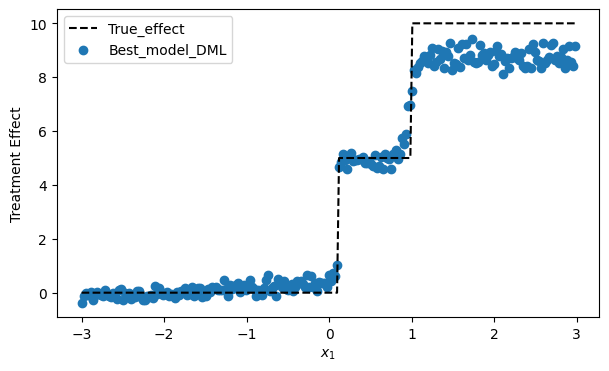

In [20]:
"""CausalForestDMLの推定結果を可視化"""
from matplotlib import pyplot as plt  # noqa: E402

best_model_name_dml = min(results_dml, key=results_dml.get)
best_model_dml = models_dml[best_model_name_dml]
DML_pred = best_model_dml.effect(X_test)  # X_testに基づいて処置効果を予測

# 結果を可視化
plt.figure(figsize=(7, 4))
plt.plot(
    X_test[:, 1],
    np.apply_along_axis(treatment_effect, 1, X_test),
    color="black",
    ls="--",
    label="True_effect",
)
plt.scatter(X_test[:, 1], DML_pred, label="Best_model_DML")
plt.xlabel("$x_1$")
plt.ylabel("Treatment Effect")
plt.legend()
plt.show()

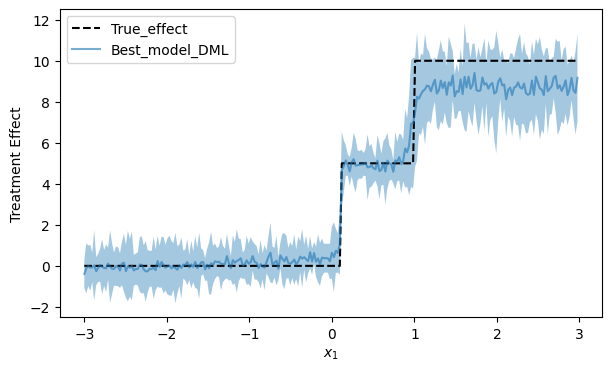

In [21]:
"""信頼区間の表示"""
lb, ub = best_model_dml.effect_interval(X_test, alpha=0.01)

# 結果を可視化
plt.figure(figsize=(7, 4))
plt.plot(
    X_test[:, 1],
    np.apply_along_axis(treatment_effect, 1, X_test),
    color="black",
    ls="--",
    label="True_effect",
)
plt.plot(X_test[:, 1], DML_pred, label="Best_model_DML", alpha=0.6)
plt.fill_between(X_test[:, 1], lb, ub, alpha=0.4)
plt.xlabel("$x_1$")
plt.ylabel("Treatment Effect")
plt.legend(loc="upper left")
plt.show()

出力結果から、CausalForestDMLの推定結果は、信頼区間の幅も狭く、推定精度が高いことがわかる
ちなみに他の今まで出てきたメタラーナーと異なり、DMLでは連続値も対応可能

### 5.4.5 DMLの課題

DMLでは交絡変数が存在せず、条件付き独立性を見たしていることが前提。条件付き独立性を満たしていない場合は、

1. バックドア基準により交絡変数を特定し、交絡を調整する
   [第2章](../chap1_4/chap2.ipynb#2-因果推論の基礎)で説明があった自動で交絡を特定する方法を用いる
   ただし、DMLは"Bad Controls"(制御すべきでない変数)の影響を強く受ける。このBad Controlsの影響でバイアスが発生するとされる。
   Bad Controlsが含まれないよう、ドメイン知識によりバイアスを生む変数を除くなどの対応が必要
2. 感度分析([6章](./chap6.ipynb#6-感度分析)で後述)を使用する
   未観測の交絡因子の影響を考慮したうえで、どの程度バイアスが発生するか検証し、影響が小さい場合はその交絡を無視する。

## 5.5 CATEを推定するその他の方法

### 5.5.1 Causal forest

因果効果の異質性を特定する問題に適用される。例えば、処置の効果が最大となるような集団・個体を見つけるなど。

特徴

* 高次元の共変量を扱える
* ノンパラメトリックな手法を用いて非線形なデータを扱える、かつ信頼区間を表示可能

アルゴリズムの概要

1. 元のデータセットから複数のブートストラップサンプリングを行い、複数のサブセットを生成
2. 各サブセットに対して回帰木(Regression Tree)で学習させ、サブセットにおける因果効果を推定
3. 複数の回帰木を組み合わせて(forest)、全体と
   しての因果効果を推定

### 5.5.2 Causal BART

BART(Bayesian Additive Regression Trees): 回帰木をベースとしたノンパラメトリック回帰の手法。他の一般的な因果推論手法と比較して比較的高性能

1. 予測のために設計された正則化モデルは、因果効果の推定でバイアスを生じる事がある
   → forestを活用して
2. 処置効果の異質性などの影響により、推定した因果効果が大きくばらつくような場合、単純な正則化ではCATEの推定値の分散を適切に制御できない
   →

といった問題に対し、Causal forestと同様に複数の回帰木を組み合わせたforestを活用いて多様なデータのパターンを捉えつつ、傾向スコアの事前分布を用いることで、処置効果の異質性に対しても正則化を適切に行う。

## 5.6 自然実験への機械学習の適用

[第3章](../chap1_4/chap3.ipynb#3-基本的な因果推論の手法)で説明のあった自然実験も近年発展しているが、特に機械学習を用いてCATEを推定する研究について述べる。

* DiD → Double/De-biased Machine Leaning for Difference-in-Difference Models
* RDD → Automated Local Regression Discontinuity Design Discovery
* 操作変数法 → DRIV(後述)、DeepIV

DRIV(MicrtosoftやTripAdvisorの取り組み)について説明する

操作変数法の前提条件は、以下の3つだった。

1. ZとTは関連する($Cov(Z, T) \neq 0$)
2. ZがTを通してのみYに影響を与え、Tを通さない場合Yに影響を与えない(除外制約)
3. ZとYは共通の原因(Common causes)を持たない

しかし2と3を満たすことが困難という課題があり、せいぜいがドメイン知識を用いた検証ができる程度だった。

TripAdvisorの、会員登録を促進し、ユーザーのエンゲージメントを高める施策

課題

* 会員登録とエンゲージメントの双方に影響を与えるようなユーザー属性や嗜好性(交絡因子)を除外する必要がある
* 未観測の交絡因子に対応する必要がある
* 単純なA/Bテストの実施が困難(会員登録はコントロールできないため)

![図5.19](images/chap5/image-9.png)
![図5.20](images/chap5/image-10.png)

1. 会員登録の促進はユーザーのエンゲージメントを高める効果があるか?

   * ワンクリックでの簡単な会員登録
   * 通常の会員登録
     をランダムに割り振る。これを操作変数Zとし、変数操作法を用いて会員登録のしやすさの効果を推定

   ![図5.21](images/chap5/image-11.png)

   これにより操作変数法の3条件を満たすことができる

   1. ワンクリック登録Zと会員登録しやすくなることTは関連している(関連性)
   2. ワンクリック登録の割当は完全ランダムなので、ユーザーエンゲージメントYに直接関連しない。かつ、会員登録以外の因子とも関連しない
   3. ワンクリック登録とユーザーエンゲージメントは共通の原因を持たない

   また、操作変数法は平均因果効果CACE(LATE)を推定する手法
2. どのユーザーに対してこの施策を実施すべきか?
   古典的なパラメトリックな操作変数法では、変数の種類が膨大かつ、複雑な効果を推定するのが困難なんどえ、機械学習を用いてメタラーナーのようにCATEの推定を推定を試みる
   今回の事例では、ランダムにワンクリックの割当をしたうえで、ユーザー400万人の膨大なデータに対して機械学習を用いてCATEを推定

さらに、DRIVでは[第4章](../chap1_4/chap4.ipynb#443-回帰)のSHAPを使用できるので解釈性が高い。

## 5.7 因果的意思決定

### 5.7.1 因果的意思決定とは何か

因果的意思決定(Causal Decision Making): 期待効用が最大となる選択肢を選ぶための方法

特定の目的や制約条件下で最適な方策(Policy)を学習

* 方策学習(Policy Leaning)
* オフ方策評価(Off-Policy Evaluation: OPE)

これまでの処置有り無し($T=1, 0$)の考え方を拡張し$A_i$を導入する。

* $Y_i$: ユーザー$i$の結果変数
* $X_i$: ユーザー$i$の持つ共変量
* $A_i$: どの選択肢を取るか。選択肢の数だけ存在する(選択肢3つであれば1,2,3)
* $\pi(A_i | X_i)$: 共変量$X_i$のユーザーが、選択肢$A_i$を選ぶ確率。確率的な意思決定モデルと呼ぶ
* $V(\pi)$: ユーザー$i$が確率$\pi(A_i | X_i)$に従って選択肢$A_i$を選んだ場合の期待効用

とすると、$V(\pi)$は以下で表される

$$
V(\pi) = E\left[ Y_i \left(\pi(A_i|X_i)\right)\right]
$$

この$V(\pi)$を最大化する$\pi^{*}$を求める必要があるため、その式は以下

* $argmax\{a | b\}$: aを最大化するbの集合を返す
* $\Pi$: すべての方策空間を表す

$$
\pi^{*} = argmax\{V(\pi)\colon \pi \in \Pi\}
$$

また、期待効用を最大化する$\pi^*$を見つけることは、$R(\pi)$を最小化することと同義

* $sup \{V(\pi^{\prime})\colon \pi \in \Pi \}$: すべての方策空間$\Pi$から、最適な方策$\pi^\prime$を選んだときの、最大の期待効用
* R: Regret(後悔)。最適な方策$\pi^\prime$の効果と、特定の方策$\pi$の差

$$
R(\pi) = sup \{V(\pi^{\prime}) \colon \pi \in \Pi \} - V(\pi)
$$

以降はRegretを使用する

### 5.7.2 なぜMSE(Man Squared Error)ではなくRegretを使用するのか

* MSE: 真の因果効果(CATE)と予測値の間の誤差を小さくするための評価方法なので、例えば処置を適用するべきか、するべきでないか(言い換えると処置適用時の因果効果は正か負か)選ぶといった問題設定で使用すると、誤差は小さくても予測値の正負が真の因果効果と逆になるモデルを採用する可能性があり不適当
  因果効果の量の把握や、推定精度の把握のために使うべき
* Regret: "最良の選択肢の期待効用 - モデルを使用して得られる期待効用"を最小化する指標なので、複数の選択肢から期待効用が最大のものを選ぶ問題においてはこちらのほうが良い

```
問題設定が両者でズレていないか?イマイチ記述が理解できない
```

予測精度が高いことと、処置の有無を割り当て(分類)が得意かどうかは一致しない。逆に言えば、問題設定・意思決定者がどの指標を重視するかによって吟味する必要がある。

Regretの注意点
* 最適な行動を事前に知ることはできない(試行して比較する必要がある)
* 複数の行動の結果を比較できない状況では使用できない
* ただし最適な行動を事前に把握できていなくても、データから比較的ロバストな推定をすることで、期待効用だ最大となる選択肢を選ぶ方法が提案されている

### 5.7.3 因果的な意思決定(OPE/OPL)の実行(文献などの紹介)

因果的意思決定の実行にあたり、OPE/OPLはライブラリが多い
* SCOPE-RL
* OPEN Bandit Pipeline
* VowpalWabbit
* 文脈付きバンディット(Contextual Bandit, OPEの1種): AutoML、Google Cloud上で使用可能

### 5.7.4 因果的意思決定(OPE/OPL)の課題

* 未観測の交絡因子の影響: これまでの因果推論の手法と同様。[第6章](./chap6)で説明する部分識別のバウンド(Partial identification bounds)を設定する方法がある
* その他: Uehara, Shi, and Kallus (2022)を参照
